# Librerías

In [1]:
## Manipulación de datos, gráficos y demás
import random # Para setear semilla
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

## Para CNN
import keras # Paquete para correr redes
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Image augmentation (Sección 10.3.4 de James)
from scikeras.wrappers import KerasClassifier # Para el Grid Search del modelo
from sklearn.model_selection import GridSearchCV # Para el Grid Search del modelo
from tensorflow.keras.models import Sequential # Para la creación del modelo 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D # Para las capas del modelo
from tensorflow.keras.callbacks import EarlyStopping # Para el earlystopping del modelo, en caso de ser necesario

## Importación de imágenes

In [4]:
# Seteo cuál es el path a las carpetas que contienen a las imágenes de entrenamiento y validación
train_path = '.\\img\\train\\'
val_path = '.\\img\\val\\'

Found 215 files belonging to 2 classes.


## Visualización de imágenes

In [26]:
os.listdir(train_path+'\\kirmizi')[3]

'1001.jpg'

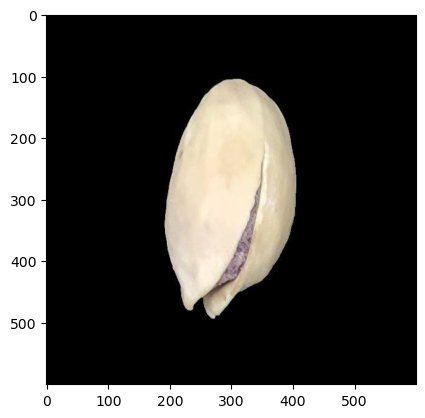

In [3]:
# Printeo alguna de las imágenes de la especie Kirmizi
plt.imshow(imread(train_path+'\\Kirmizi'+'\\1001.jpg'))
image_kirmizi = imread(train_path+'\\Kirmizi'+'\\1001.jpg')

In [28]:
# Tamaño de la imagen (son todas de igual tamaño)
image_kirmizi.shape

(600, 600, 3)

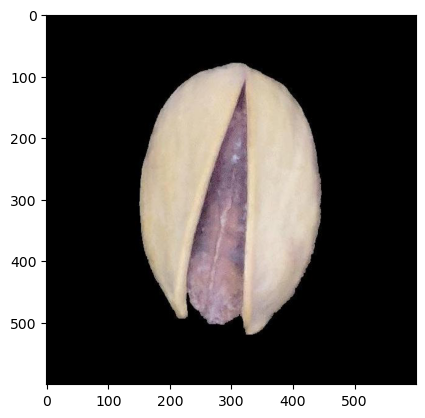

In [29]:
# Printeo alguna de las imágenes de la especie Siirt
plt.imshow(imread(train_path+'\\siirt'+'\\4.jpg'))

## Image augmentation

In [4]:
# Creo la función que me va a hacer la "image augmentation" para mi dataset
image_gen = ImageDataGenerator(rotation_range = 20,     # Rotación máxima: 20°
                               width_shift_range = .1,  # Desplazamiento de la anchura máxima: +-5% (por eso ponemos .10)
                               height_shift_range = .1, # Desplazamiento de la altura máxima: +-5% (por eso ponemos .10)
                               rescale= 1/255,          # Rescalar la imagen para normalizarla entre 0 y 1
                               shear_range = .1,        # Parámetro de distorsión máximo: 10%
                               zoom_range = .1,         # Parámetro de zoom máximo: 10%
                               horizontal_flip = True,  # Permitir imágenes de tipo espejo
                               fill_mode = 'nearest')

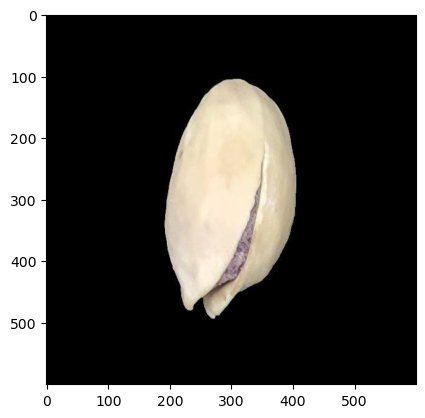

In [31]:
# Esta es la imagen original
plt.imshow(image_kirmizi)

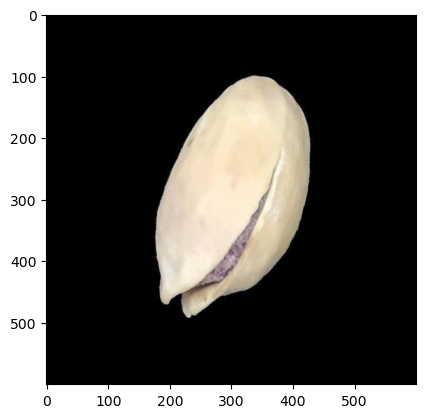

In [32]:
# Esta es una imagen generada a partir de la de arriba. Cada vez que lo corra, va a generar una imagen nueva
plt.imshow(image_gen.random_transform(image_kirmizi))

### Train set image augmentation

In [6]:
random.seed(7777777)
train_image_gen = image_gen.flow_from_directory(
    train_path,               # Le asigno el path del training set
    target_size = (100, 100), # Especifico los parámetros de largo y ancho
    color_mode = 'rgb',       # La escala de color
    batch_size = 16,          # Tamaño de subgrupos de imágenes (1717 / 16 = 108 "pasos" de cada epoch)
    class_mode = 'binary')    # Especifico el tipo de clasificación

Found 1718 images belonging to 2 classes.


In [36]:
## Indicadora del número que el asigna a cada clase. Como este caso es binario, obviamente asigna 0 y 1
train_image_gen.class_indices

{'kirmizi': 0, 'siirt': 1}

### Validation set

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
random.seed(7777777)
val_image = image_gen.flow_from_directory(
    val_path,                # Le asigno el path del training set
    target_size = (100, 100), # Especifico los parámetros de largo y ancho
    color_mode = 'rgb',       # La escala de color
    batch_size = 16,          # Tamaño de subgrupos de imágenes (1717 / 16 = 108 "pasos" de cada epoch)
    class_mode = 'binary')    # Especifico el tipo de clasificación

# Modelo con 3 capas

## Creación del modelo

In [55]:
# Definición de modelo secuencial
model_3 = Sequential()

# Primera capa convolucional
model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', ))
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Segunda capa convolucional
model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', ))
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Tercera capa convolucional
model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', ))
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Capa Flatten
model_3.add(Flatten())

# Capa Dense
model_3.add(Dense(128))
model_3.add(Activation('relu'))

# Capa dropout
model_3.add(Dropout(.5))

# Capa final
model_3.add(Dense(1, activation = 'sigmoid'))

model_3.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

## Detalles del modelo

In [35]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 128)               4

## Entrenamiento del modelo

In [56]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 50,
    min_delta = 0.005)

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
results = model_3.fit(
    train_image_gen,
    epochs = 500,
    validation_data = val_image,
    callbacks = [early_stop]
)

Epoch 1/500
108/108 [==============================] - 9s 74ms/step - loss: 0.6340 - accuracy: 0.6494 - val_loss: 0.5204 - val_accuracy: 0.7425
Epoch 2/500
108/108 [==============================] - 8s 72ms/step - loss: 0.5639 - accuracy: 0.7187 - val_loss: 0.5343 - val_accuracy: 0.7541
Epoch 3/500
108/108 [==============================] - 8s 73ms/step - loss: 0.5241 - accuracy: 0.7391 - val_loss: 0.5289 - val_accuracy: 0.7471
Epoch 4/500
108/108 [==============================] - 8s 73ms/step - loss: 0.5270 - accuracy: 0.7449 - val_loss: 0.4795 - val_accuracy: 0.7773
Epoch 5/500
108/108 [==============================] - 8s 72ms/step - loss: 0.5106 - accuracy: 0.7490 - val_loss: 0.4617 - val_accuracy: 0.7796
Epoch 6/500
108/108 [==============================] - 8s 73ms/step - loss: 0.5171 - accuracy: 0.7461 - val_loss: 0.4852 - val_accuracy: 0.7541
Epoch 7/500
108/108 [==============================] - 8s 73ms/step - loss: 0.5241 - accuracy: 0.7338 - val_loss: 0.4735 - val_accuracy:

## Guardado del modelo

In [42]:
model_3.save('100x100_3capas.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 598, 598, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 299, 299, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 297, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 148, 148, 64)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1401856)           0         
                                                                 
 dense (Dense)               (None, 128)               1

# Modelo con 2 capas

## Creación del modelo

In [ ]:
# Definición de modelo secuencial
model_2 = Sequential()

# Primera capa convolucional
model_2.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', ))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Segunda capa convolucional
model_2.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', ))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Capa Flatten
model_2.add(Flatten())

# Capa Dense
model_2.add(Dense(128))
model_2.add(Activation('relu'))

# Capa dropout
model_2.add(Dropout(.5))

# Capa final
model_2.add(Dense(1, activation = 'sigmoid'))

model_2.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

## Detalles del modelo

In [ ]:
model_2.summary()

## Entrenamiento del modelo

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 50,
    min_delta = 0.005)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
results = model_2.fit(
    train_image_gen,
    epochs = 500,
    validation_data = val_image_gen,
    callbacks = [early_stop]
)

## Guardado del modelo

In [8]:
model_2.save('100x100_2capas.keras')


KeyboardInterrupt



# Extras

## Gráfico de entrenamiento y validación

In [ ]:
## Guardo cargo la información a utilizar
losses = pd.DataFrame(model.history.history)
losses[['accuracy', 'val_accuracy']].plot()
#plt.ylim([0, 1])
plt.show
#losses[['accuracy', 'val_accuracy']].plot()

## Grid search

In [ ]:
## Función que varía el optimizador y la cantidad de capas convolucionales de la red para ver con cuál trabajo
def create_model(optimizer, conv_layers):
  # Inicializar el constructor
    model = keras.Sequential()

    for i in range(conv_layers):
        num_filters = 32 if i == 0 else 64
        # Capa oculta
        model.add(Conv2D(filters = num_filters, kernel_size = (3, 3), input_shape = (100, 100, 3), activation = 'relu', ))
        model.add(MaxPooling2D(pool_size = (2, 2)))

    # Capa Flatten
    model.add(Flatten())
    
    # Capa Dense
    model.add(Dense(128))
    model.add(Activation('relu'))
    
    # Capa dropout
    model.add(Dropout(.5))
    
    # Capa final
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compilar el modelo
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

## Modelo a utilizar como input de la función GridSearchCV
# modelCV = KerasClassifier(build_fn=create_model, verbose=0)
# modelCV = create_model()

In [ ]:
## Diccionario con grilla de valores de hiperparámetros
conv_layers = [1, 2, 3]
optimizers = ['sgd', 'rmsprop', 'adam']

## Implementación de grid search
for conv_layer in conv_layers:
    for optimizer in optimizers:
        mod = create_model(optimizer, conv_layer)
        mod.fit(train_image_gen, epochs = 10, verbose=0)
        mod.evaluate(val_image_gen)[1]

## Data augmentation image

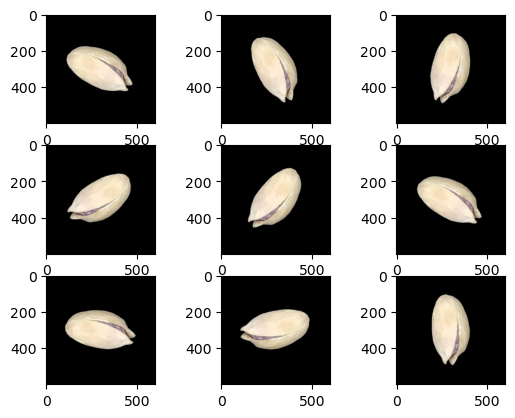

In [5]:
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img(train_path+'\\Kirmizi'+'\\1001.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # generate batch of images
 batch = it.next()
 # convert to unsigned integers for viewing
 image = batch[0].astype('uint8')
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()